In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential ,load_model
from tensorflow.keras.layers import Dense, Input,MaxPooling2D,Conv2D,Flatten
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample # downsample the dataset
from sklearn.model_selection import train_test_split # split data into training and testing sets
from sklearn.svm import SVC # this will make a support vector machine for classificaiton
from sklearn.model_selection import GridSearchCV #this will do cross validation
from sklearn.metrics import confusion_matrix # this creates a confusion matrix
from sklearn.decomposition import PCA # to perform PCA to plot the data
from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from PIL import Image
import random
import glob
import os
import cv2
import pandas as pd

In [ ]:
#!unzip /content/drive/My Drive/data/resizedImage256/resizedImage256.zip -d /content/drive/My Drive/data/resizedImage256/data/resizedImage256/

Archive:  /content/drive/My Drive/resizedImage256.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/drive/My Drive/resizedImage256.zip or
        /content/drive/My Drive/resizedImage256.zip.zip, and cannot find /content/drive/My Drive/resizedImage256.zip.ZIP, period.


In [3]:
# pre proccessing

# Specify the directory path
directory_path = '/content/drive/My Drive/data/resizedImage256/'

# Get all files in the directory
files = glob.glob(directory_path + '/*')
file_types = set()
img_height = 256
img_width = 256
Xdata = []
Ydata = []
for a in files:
    #file_name, file_extension = os.path.splitext(a)
    #file_types.add(file_extension)
    image = cv2.imread(a)
    #image = cv2.resize(image, (img_width,img_height))
    #Image.fromarray(image).save('./resizedImage256/'+file_name.replace("./data\\", "")+file_extension)
    #print('./data/resized256/'+file_name+file_extension)
    #cv2.imwrite('./resizedImage256/'+file_name+file_extension, image)
    image = image / 255.0 # for normallization and having better accuracy
    Xdata.append(image)
    Ydata.append(int("happy" in a))

In [4]:
X_train_data = []
X_test_data = []
Y_train_data = []
Y_test_data = []

data_size = len(Xdata)
train_size = int(.80 * data_size);

for i in range(0,train_size):
    rand_index = random.randint(0, len(Xdata)-1)
    X_train_data.append(Xdata[rand_index])
    Y_train_data.append(Ydata[rand_index])
    del Xdata[rand_index]
    del Ydata[rand_index]

X_test_data = Xdata.copy()
Y_test_data = Ydata.copy()
print("whole data "+str(len(Xdata)))
print("train data "+str(len(X_train_data)))
print("test data "+str(len(X_test_data)))


whole data 398
train data 1590
test data 398


In [6]:
#print("each data shape "+str(Xdata[0].shape))
X_train_data = np.array(X_train_data, dtype=np.float32)
Y_train_data = np.array(Y_train_data, dtype=np.float32)
X_train_data.shape

(1590, 256, 256, 3)

**bold text**# New Section

In [7]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), input_shape=(img_width, img_height, 3)),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(filters=16,kernel_size=(3, 3)),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 125, 125, 16)        │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 62, 62, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 61504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │      15,745,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,767,313 (60.15 MB)

 Trainable params: 15,767,313 (60.15 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [9]:
model.fit(X_train_data, Y_train_data,batch_size=128, epochs=400,verbose=1)


Epoch 1/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 825ms/step - accuracy: 0.5398 - loss: 12.2452
Epoch 2/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 164ms/step - accuracy: 0.5066 - loss: 2.1512
Epoch 3/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.5739 - loss: 0.7176
Epoch 4/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.6426 - loss: 0.6652
Epoch 5/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.6461 - loss: 0.7531
Epoch 6/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - accuracy: 0.5013 - loss: 6.6471
Epoch 7/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.6153 - loss: 0.7085
Epoch 8/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.6542 - loss: 0.6392
Epoch 9/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.5244 - loss: 4.5938
Epoch 10/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.5762 - loss: 0.6841
Epoch 11/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.6409 - loss: 0.6166
Epoch 12/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accura

In [10]:
model.save('/content/drive/My Drive/models/happy-sad.keras')

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


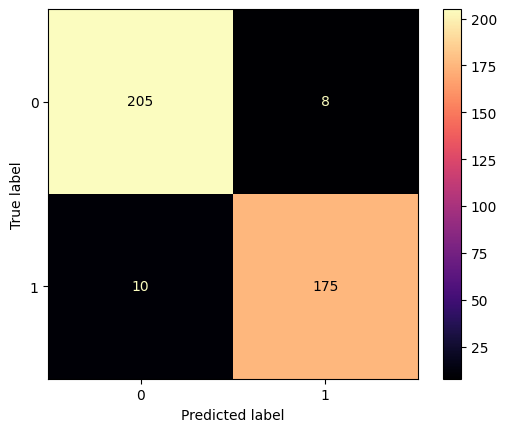

Precision: 0.9563
Accuracy: 0.9548
Sensitivity (Recall): 0.9459


In [23]:
X_test_data = np.array(X_test_data, dtype=np.float32)
Y_test_data = np.array(Y_test_data, dtype=np.float32)
predictions1 = model.predict(X_test_data)
tensor_predictions = (np.array(predictions1)>= 0.5).astype(int)
plot_confusion_mat(tensor_predictions,Y_test_data,"Tensor flow model confusion matrix")

In [12]:
def plot_confusion_mat(predictions,y_test1,title):
    cm = confusion_matrix(y_test1, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap = 'magma')
    #plt.savefig('images/'+title+'.png')
    plt.show()
    # Calculate precision, accuracy, and sensitivity
    precision = precision_score(y_test1, predictions)
    accuracy = accuracy_score(y_test1, predictions)
    sensitivity = recall_score(y_test1, predictions)

    print(f'Precision: {precision:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Sensitivity (Recall): {sensitivity:.4f}')